*Note: The gym window might not close automatically after each rollout. In between cells, just leave it open.*

**Imports**

In [7]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
from thesis.main import main, rollout
from thesis.util import animate
from IPython.display import display, HTML
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from IPython.display import Image

**Mathematical Pendulum**

In [8]:
from gym.envs.registration import register
# Register environment
register(
    id='MathPendulum-v0',
    max_episode_steps=100,
    entry_point='sb3_contrib.common.envs.pendulum.math_pendulum_env:MathPendulumEnv'
)

Error: Cannot re-register id: MathPendulum-v0

Define a safe region. Here we use a precomputed region of attraction (defined via LQR constraints that is used as fail-safe backup).<br>Once the pendulum violates the safety restriction, we turn its color orange.<br><br>Note: The safe_region has been manually passed a posteriori, since the environment only needs it for visualisation purposes.<br>Thus,  here we do not use the safe region. We will need it later, though! 

In [9]:
from sb3_contrib.common.safety.safe_region import SafeRegion
import numpy as np
from numpy import pi

from sb3_contrib.common.safety.safe_region import SafeRegion
max_thdot = 5.890486225480862
vertices = np.array([
        [-pi, max_thdot],  
        [-0.785398163397448, max_thdot],  
        [pi, -max_thdot],
        [0.785398163397448, -max_thdot]
])
# Pass as vertex or halfspace representation.
safe_region = SafeRegion(vertices=vertices)

Sample from continuous action space.

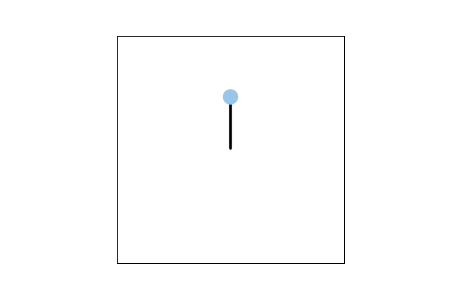

In [17]:
# Initialise environment
env = gym.make('MathPendulum-v0')
# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

#frames = rollout(env, render=True, rgb_array=True, sleep=.1)
#anim = animate(frames, dpi=75)
#anim.save('gifs/animation.gif', writer='imagemagick', fps=60)
Image(filename="gifs/animation.gif")

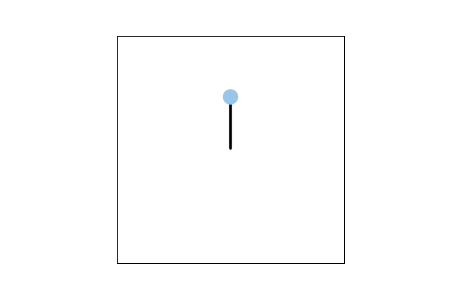

In [20]:
with open('gifs/animation.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

Our RL policy should work with discrete actions. Nevertheless, some safety approaches or fail-safe controllers might work with continuous actions. The wrapper **action_discretizer** wraps environment using a continuous action space and transforms it into a discrete using one.

In [11]:
from sb3_contrib.common.wrappers.action_discretizer import ActionDiscretizer
from gym.spaces import Discrete

# Initialise environment
env = gym.make('MathPendulum-v0')
# Discretize actions
env = ActionDiscretizer(
    env=env,
    disc_action_space=Discrete(15), #Pass the new discrete action space
    transform_fn=lambda a:2*(a-7) #Pass an unbounded transformation function (discrete -> continuous action)
)

For further safety approaches down below, we might need a fail-safe controller. Here we utilise a LQR-controller. The MathPendulumEnv already implements it as part of the **safe_action** method (can be triggered manually for debugging purposes).

In [12]:
# Initialise environment
env = gym.make('MathPendulum-v0')
# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

frames = rollout(env, render=True, rgb_array=True, env_safe_action=True, sleep=.1)
#HTML(animate(frames, dpi=75).to_html5_video())

**Safety Wrappers**

Every safety wrapper expects to be given a **SafeRegion** (see above). Further parameters depend on the specific approach.

<br>The **SafetyShield** wrapper expects to be given to functions:<br>

- **is_safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion, float], bool]]<br>
Given the env, the safe region and the action, this method returns a bool if the action would be safe to take. *Will most likely look like below?*<br><br>

- **safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion], np.ndarray]]<br>
Given the env and the safe region; returns a fail-safe action to be taken if the policy's action is unsafe. <br>

Optionally a third function **punishment_fn** can be given.<br>

- punishment_fn: Optional[Union[str, Callable[[gym.Env, SafeRegion, float, float], float]]] = None
Given the env, the safe region, the policy's action and the shield's action. Is only called whenever the shield is active. Returns a reward which is **added** to the reward, i.e. most likely you want to return a negative reward.

These functions can be passed as unbounded functions or, if already implemented in the environment, as according str.

In [8]:
from sb3_contrib.common.wrappers import SafetyShield

def is_safe_action(env: gym.Env, safe_region: SafeRegion, action: float):
    # Specific to environment
    theta, thdot = env.state
    state = env.dynamics(theta, thdot, action) 
    return state in safe_region

def punishment_fn(env: gym.Env, safe_region: SafeRegion, action: float, action_shield: float) -> float:
                return -abs(action - action_shield)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyShield
env = SafetyShield(
                env=env,
                safe_region=safe_region,
                is_safe_action_fn=is_safe_action,
                safe_action_fn="safe_action", #Already implemented in env (LQR controller)
                punishment_fn=punishment_fn)

# Discretize actions
env = ActionDiscretizer(
    env=env,
    disc_action_space=Discrete(15), #Pass the new discrete action space
    transform_fn=lambda a:2*(a-7) #Pass an unbounded transformation function (discrete -> continuous action)
)

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Takes random (discrete) actions; but wrapped in SafetyShield
frames = rollout(env, render=True, rgb_array=True, sleep=.1)
#HTML(animate(frames, dpi=75).to_html5_video())